<a href="https://colab.research.google.com/github/Sergio432/IA-s-IB-2022-ordinary-class/blob/main/PIA_InteligenciaArtificial_BrainTumorDetection(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import TensorFlow

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from zipfile import ZipFile #Para la descarga de los archivos Zip de Kaggle

import os, glob #para trabajar los archivos descargados
import cv2

from keras import models
from keras import layers
from keras.models import Sequential

import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Librerías a utilizar
import matplotlib.pyplot as plt # generar gráficos
import numpy as np # generar arreglos
import pandas as pd # cargar conjuntos de datos externos
import sklearn.linear_model # contiene diferentes modelos de ML

###Download and prepare the dataset from kaggle


In [ ]:
#install Kaggle using an API
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
  #it crates a kaggle folder  and gives permision for jason to act
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 60% 9.00M/15.1M [00:00<00:00, 39.7MB/s]
100% 15.1M/15.1M [00:00<00:00, 55.8MB/s]


In [ ]:
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip" #Archico de donde se extraeran datos

with ZipFile(file_name,'r') as zip: #Extrae todos los archivos del zip
  zip.extractall()
  print('Done')

Done


In [ ]:
MAIN_DIR = "/content/brain_tumor_dataset"
SEED = 40
os.listdir(MAIN_DIR)

['yes', 'no']

In [ ]:
subdirs = os.listdir(MAIN_DIR)[:2]
for subdir in subdirs:
    print(f"{subdir} contains {len(os.listdir(MAIN_DIR+'/'+subdir))} images")

yes contains 155 images
no contains 98 images


In [ ]:
def load_images(folder):    
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.resize(img, (128,128))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1
    
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((253, 128, 128, 3), (253,))

**Visualization**

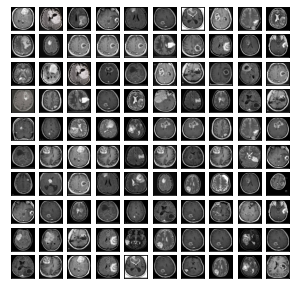

In [ ]:
plt.figure(figsize=(5,5))
for i in range(100):
    plt.subplot(10,10, i+1)
    idx = np.random.randint(0, 97) #98 imágenes de NO
    plt.imshow(data[idx], cmap='gray')
    plt.xticks([])
    plt.yticks([])

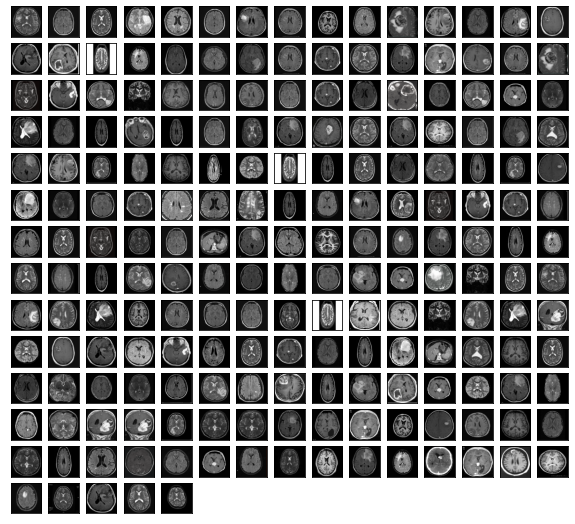

In [ ]:
plt.figure(figsize=(10,10))
for i in range(200):
    plt.subplot(15,15, i+1)
    idx = np.random.randint(98, 252) #155 imágnes de YES
    plt.imshow(data[idx], cmap='gray')
    plt.xticks([])
    plt.yticks([])

**Data normalization**

In [ ]:
norm_data = data / 255. 
norm_data.shape, norm_data[0]

((253, 128, 128, 3), array([[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],
 
        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],
 
        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],
 
        ...,
 
        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157,

### Create the convolutional base

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-trai

**Add Dense layers on top**


In [ ]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 50176)            

### Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(norm_data, labels, epochs=10, validation_split=0.20)

Epoch 1/10
7/7 [==============================] - 6s 846ms/step - loss: 0.0506 - accuracy: 0.9802 - val_loss: 1.7651 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 6s 836ms/step - loss: 0.0290 - accuracy: 0.9901 - val_loss: 1.5783 - val_accuracy: 0.5882
Epoch 3/10
7/7 [==============================] - 6s 829ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 3.5377 - val_accuracy: 0.3922
Epoch 4/10
7/7 [==============================] - 6s 904ms/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 2.1371 - val_accuracy: 0.5882
Epoch 5/10
7/7 [==============================] - 7s 935ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 3.1994 - val_accuracy: 0.4706
Epoch 6/10
7/7 [==============================] - 6s 841ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.4214 - val_accuracy: 0.5882
Epoch 7/10
7/7 [==============================] - 6s 921ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 3.8597 - val_accuracy: 0.4510
Epoch 8/10
7/7 [====

### Evaluation

In [ ]:
result = model.evaluate(norm_data, labels, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 90.12%
Loss: 0.7503


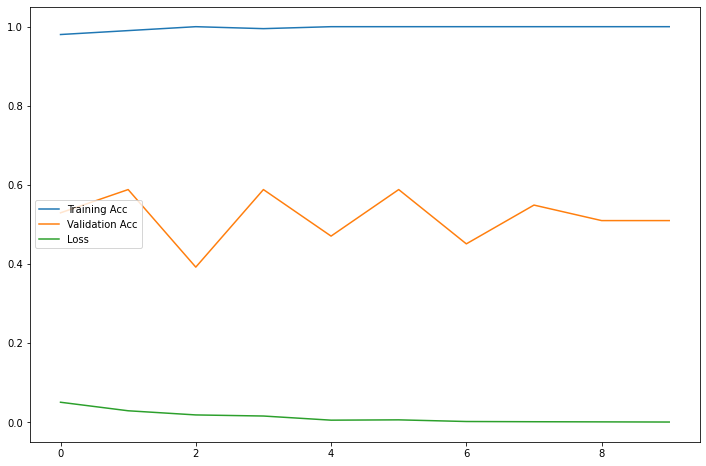

In [ ]:
histdf = pd.DataFrame(history.history)

plt.figure(figsize=(12,8))
plt.plot(histdf['accuracy'], label='Training Acc')
plt.plot(histdf['val_accuracy'], label='Validation Acc')
plt.plot(histdf['loss'], label='Loss')
plt.legend()
plt.show()